In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import torch
from torch import nn, optim, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss, Linear, ReLU, Dropout
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.nn import global_add_pool as gsp, global_mean_pool as gmp, global_max_pool as gap

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors as desc
from rdkit.Chem import AllChem, Crippen, Lipinski, Draw

from joblib import dump, load
from Environment import one_hot_encoding_unk, featurization_parameters, atom_features
from Environment import process_single_SMILES_ST_GCN, SMILES_data_process_ST_GCN
from Environment import calculate_val_metrics, save_metrics_to_txt
from Environment import ST_GCN_non_SF, validation_ST_GCN
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torch_geometric.explain import Explainer, GNNExplainer
from IPython.display import display
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [2]:
Metric_path = './utils/Explainability/'
scaler_y_abs = load(Metric_path + 'Regression_standard_abs_y_scaler.joblib')
#scaler_y_emi = load(Metric_path + 'Regression_standard_emi_y_scaler.joblib')
#scaler_y_stokes = load(Metric_path + 'Regression_standard_stokes_y_scaler.joblib')
#scaler_y_coeff = load(Metric_path + 'Regression_standard_coeff_y_scaler.joblib')
#scaler_y_yield = load(Metric_path + 'Regression_standard_yield_y_scaler.joblib')
#scaler_y_time = load(Metric_path + 'Regression_standard_time_y_scaler.joblib')

file_path = './dataset/data_pre/Result_data_pre_include_fingerprints/'
x_pre = pd.read_csv(file_path + '07_Concatenated_data.csv')

y_pre = pd.read_csv('./dataset/data_pre/DATA_pre_use_to_predict_142.csv')
y_pre = y_pre.iloc[:,4:10] #6 real experimental values

In [3]:
pre = pd.concat([x_pre.iloc[:, 0], y_pre.iloc[:,0]], axis=1) #0->abs,1->emi,2->stokes,3->coeff,4->yield,5->time
pre_final = pre.dropna(axis=0,how='any').reset_index(drop=True)
print(pre.shape)
print(pre_final.shape)

y_pre = pre_final.iloc[:, 1]
Y_pre = scaler_y_abs.transform(y_pre.values.reshape(-1, 1))
Y_pre = pd.DataFrame(Y_pre)
combined_data_pre = pd.concat([pre_final.iloc[:,0], Y_pre], axis=1)
print(combined_data_pre.shape) 
print(pre_final.head())

feature_params = featurization_parameters()
pre_processed_data = SMILES_data_process_ST_GCN(combined_data_pre)
pre_loader = DataLoader(pre_processed_data,batch_size=32,shuffle=False)

(142, 2)
(142, 2)
(142, 2)
                                    Canonical SMILES  Absorption/nm
0  CC1(C)C(/C=C2\C(=O)C(=O)C(/C=C3\Nc4ccccc4C3(C)...          774.0
1  CN1/C(=C\C2=C([O-])/C(=C/C3=[N+](C)c4ccccc4C3(...          777.0
2  CC1(C)C(/C=C2\C(=O)C(=O)C(/C=C3\Nc4ccc5ccccc5c...          812.0
3  CN1/C(=C/C2=C([O-])/C(=C/c3sc4ccccc4[n+]3C)C(=...          782.0
4  CN1/C(=C/C2=C([O-])/C(=C/c3ccc4ccccc4[n+]3C)C(...          843.0


In [4]:
#abs
suffix = 'abs'
model = ST_GCN_non_SF().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = MSELoss()
model.load_state_dict(torch.load(Metric_path + f'ST_GCN_{suffix}_best_model.pt'))

Y_pred_pre, Y_origin_pre, loss_pre = validation_ST_GCN(model, pre_loader, DEVICE)

Y_origin_pre = scaler_y_abs.inverse_transform(Y_origin_pre)
Y_pred_pre = scaler_y_abs.inverse_transform(Y_pred_pre)

output_path = f'./Result/explainability/'
np.savetxt(output_path + f'Y_pred_ST_GCN_non_SF_{suffix}.csv', Y_pred_pre, delimiter=',')
np.savetxt(output_path + f'Y_origin_pre_{suffix}.csv', Y_origin_pre, delimiter=',')

MSE_pre = mean_squared_error(Y_origin_pre, Y_pred_pre)
RMSE_pre = np.sqrt(MSE_pre)
print(f"The RMSE_pre_{suffix}",RMSE_pre)

validation finished!
validation_loss: 0.2550
The RMSE_pre_abs 52.994205163747786


Data(x=[42, 131], edge_index=[2, 96], edge_attr=[96, 6], y=0.13329610228538513, smiles='COc1ccc(C2=[N+]3C(=Nc4c(-c5ccccc5)cc(-c5ccc(OC)cc5)n4[B-]3(F)F)C(c3ccccc3)=C2)cc1')


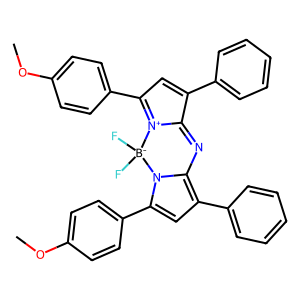

In [5]:
# Explainability
data = pre_processed_data[32]#H_BDP:14 OMe_BDP:32 
print(data)
suffix = 'OMe_BDP'

#dislay molecule structure
smiles = data.smiles
mol = Chem.MolFromSmiles(smiles)
img = Draw.MolToImage(mol, size=(300, 300))
display(img)

Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to './Result/explainability/feature_importance_OMe_BDP.png'


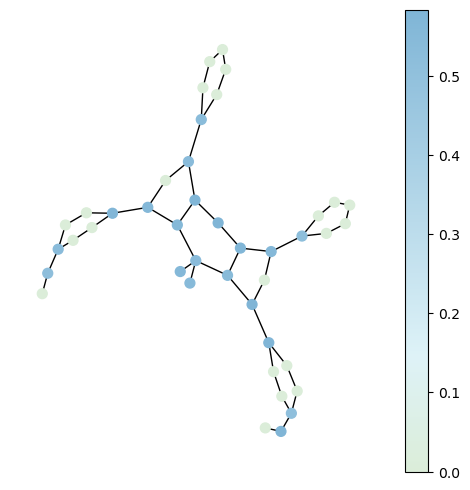

In [6]:
explainer = Explainer(
    model=model,#The model to explain.
    algorithm=GNNExplainer(epochs=200,lr=1e-3),#The explanation algorithm
    explanation_type='model',#Explains the model prediction."phenomenon": Explains the phenomenon that the model is trying to predict
    node_mask_type='attributes',#Will mask each feature across all nodes.
    edge_mask_type='object',#Will mask each edge.
    model_config=dict(
        mode='regression',#the prediction is returned as a scalar value
        task_level='graph',
        return_type='raw',#The model returns raw values.
    ),
)

explanation = explainer(data.x.to(DEVICE), data.edge_index.to(DEVICE))
print(f'Generated explanations in {explanation.available_explanations}')

node_mask = explanation.node_mask.detach().cpu().numpy()
df = pd.DataFrame(node_mask)
df.to_csv(output_path + f'node_mask_{suffix}.csv', index=False, header=False)

path = output_path + f'feature_importance_{suffix}.png'
explanation.visualize_feature_importance(path, top_k=20)
print(f"Feature importance plot has been saved to '{path}'")

edge_mask = explanation.edge_mask.detach().cpu().numpy()
df2 = pd.DataFrame(edge_mask)
df2.to_csv(output_path + f'edge_mask_{suffix}.csv', index=False, header=False)

g = nx.Graph()
# add node
node_list = list(range(data.x.shape[0]))
g.add_nodes_from(node_list)

num_b = data.edge_index.shape[1]
# add edge
node_a = ((data.edge_index)[0][0:num_b]).tolist()
node_b = ((data.edge_index)[1][0:num_b]).tolist()

edge = []
for item in zip(node_a,node_b):
    edge.append(item)
g.add_edges_from(edge)

colors = [(0.86, 0.93, 0.85), (0.87, 0.95, 0.97), (0.50, 0.71, 0.84)] 
nodes = [0, 0.25, 1]  # Positions of the colors along the gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))

suffix2 = 116
node_importance = node_mask[:,suffix2]
pos = nx.spring_layout(g, seed=50) #0：H_BDP 50：OMe_BDP


plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(g, pos, alpha=1)
node = nx.draw_networkx_nodes(
    g,
    pos,
    nodelist=list(g.nodes),
    node_size=50,
    node_color=node_importance,
    #cmap=plt.cm.,
    cmap=custom_cmap
)

plt.colorbar(node)
plt.axis("off")

plt.savefig(output_path + f'Figure_{suffix}_{suffix2}.pdf', format='pdf')
plt.savefig(output_path + f'Figure_{suffix}_{suffix2}.png', format='png')

plt.show()